Використовуючи бібліотеку PyTorch, створіть генеративно-змагальну мережу (GAN) для генерації зображень цифр MNIST.
1) Завантажте набір даних MNIST з використанням torchvision.datasets.
2) Створіть генератор, який приймає на вхід випадковий вектор з шумом та генерує зображення цифр MNIST.
3) Створіть дискримінатор, який приймає на вхід зображення цифр MNIST та визначає, чи є це реальне зображення чи згенероване генератором.
4) Обидві моделі повинні мати декілька шарів зі зменшенням розмірності зображення, використовуючи згортувальні та пулінгові шари.
5) Навчіть моделі генерувати нові зображення цифр MNIST, використовуючи взаємодію генератора та дискримінатора з використанням функції втрат GAN (adversarial loss).
6) Після навчання, виведіть кілька згенерованих зображень та порівняйте їх з Оригінальними зображеннями з набору даних MNIST.

In [26]:
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms


# Load the MNIST dataset
mnist_dataset = datasets.MNIST(root='data', train=True, transform=transforms.ToTensor(), download=True)

# Create a data loader for the MNIST dataset
batch_size = 64
data_loader = torch.utils.data.DataLoader(mnist_dataset, batch_size=batch_size, shuffle=True)

# Get a batch of real images
real_images, labels = next(iter(data_loader))

In [15]:
class Generator(nn.Module):
    def __init__(self, noise_dim=100, image_dim=28*28, hidden_dim=256):
        super(Generator, self).__init__()
        self.noise_dim = noise_dim
        self.image_dim = image_dim
        self.hidden_dim = hidden_dim
        
        self.fc1 = nn.Linear(noise_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, image_dim)
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.tanh(x)
        return x.view(-1, 1, 28, 28)


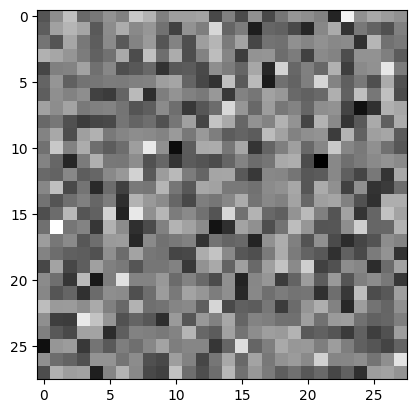

In [21]:
# Instantiate the generator
gen = Generator()

# Generate a random noise vector
noise = torch.randn(1, gen.noise_dim)

# Generate an image from the noise vector
image = gen(noise)

# Display the image
import matplotlib.pyplot as plt
plt.imshow(image.squeeze().detach().numpy(), cmap='gray')
plt.show()


In [22]:
class Discriminator(nn.Module):
    def __init__(self, image_dim=28*28, hidden_dim=256):
        super(Discriminator, self).__init__()
        self.image_dim = image_dim
        self.hidden_dim = hidden_dim
        
        self.fc1 = nn.Linear(image_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = x.view(-1, self.image_dim)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x


In [23]:
import torch.optim as optim

# Instantiate the discriminator and the generator
disc = Discriminator()
gen = Generator()

# Define the optimizer for the discriminator
lr_disc = 0.0002
betas_disc = (0.5, 0.999)
optimizer_disc = optim.Adam(disc.parameters(), lr=lr_disc, betas=betas_disc)

In [24]:
# Generate a fake image using the generator
noise = torch.randn(batch_size, gen.noise_dim)
fake_images = gen(noise)

# Compute the discriminator's prediction for the real image and the fake image
real_pred = disc(real_images)
fake_pred = disc(fake_images)

# Compute the binary cross-entropy loss
loss_fn = nn.BCELoss()
real_loss = loss_fn(real_pred, torch.ones_like(real_pred))
fake_loss = loss_fn(fake_pred, torch.zeros_like(fake_pred))
total_loss = real_loss + fake_loss

# Backpropagate and update the discriminator's parameters
total_loss.backward()
optimizer_disc.step()